# CUNEF MUCD 2021/2022
## News Classification
Autor:  
- Antonio Tello Gómez

# 4. Metrics and Interpretability

In [27]:
#Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import pickle

#Functionalities
from collections import Counter
import sys, os
import warnings
warnings.filterwarnings('ignore')

# Explicability
import shap

# Model
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.Preprocessor import TextPreprocessor
from lightgbm import LGBMClassifier

# Métrics
from sklearn.metrics import (roc_curve, roc_auc_score, f1_score , confusion_matrix, recall_score, 
                             precision_score, classification_report, precision_recall_curve, accuracy_score)
from lightgbm import plot_importance

In [7]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

## Loading Data & Model

In [8]:
xtrain = pd.read_csv('../data/train/X_train.csv')['full_text']
ytrain = pd.read_csv('../data/train/y_train.csv')['label']
xtest = pd.read_csv('../data/test/X_test.csv')['full_text']
ytest = pd.read_csv('../data/test/y_test.csv')['label']

In [9]:
lgbm = pickle.load(open('../models/' + 'optim_lgbm' + '.pkl', 'rb'))

In [10]:
ypred = lgbm.predict(xtest)
ypred_proba= lgbm.predict_proba(xtest)

In [13]:
evaluate_model(ytest,ypred, ypred_proba)

ROC-AUC score of the model: 0.9860422175471104
Accuracy of the model: 0.9435637285986049

Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       789
           1       0.94      0.95      0.94       788

    accuracy                           0.94      1577
   macro avg       0.94      0.94      0.94      1577
weighted avg       0.94      0.94      0.94      1577


Confusion matrix: 
[[741  48]
 [ 41 747]]



## Metrics

### Roc Curve

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

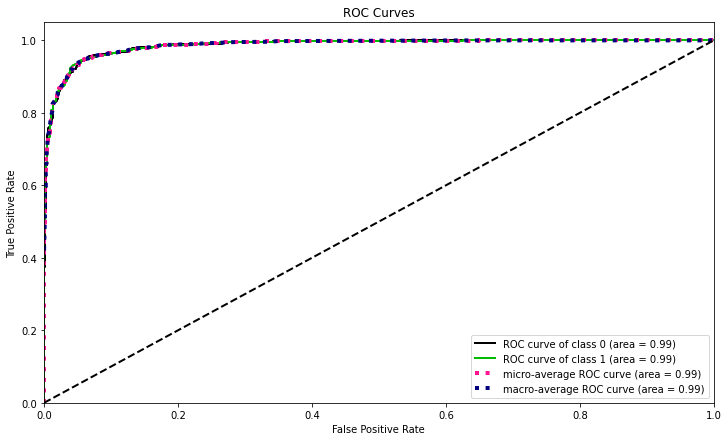

In [20]:
skplt.metrics.plot_roc(ytest, ypred_proba, figsize=(12,7))

### Confusion Matrix

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

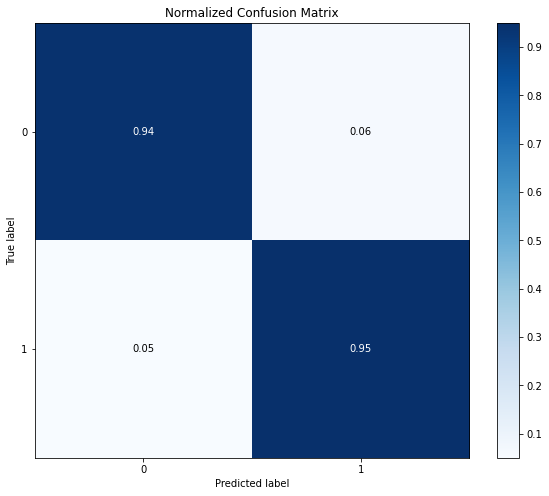

In [19]:
skplt.metrics.plot_confusion_matrix(ytest,ypred,normalize=True,figsize=(10, 8),)

### Cumulative Gain Plot 

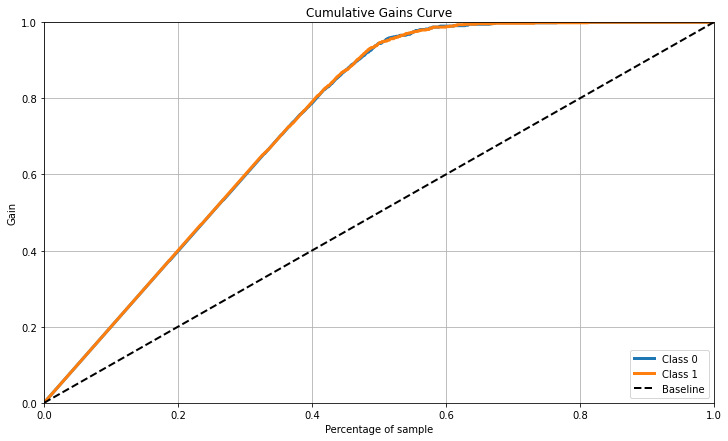

In [14]:
skplt.metrics.plot_cumulative_gain(ytest, ypred_proba, figsize=(12, 7));

### Lift Curve

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

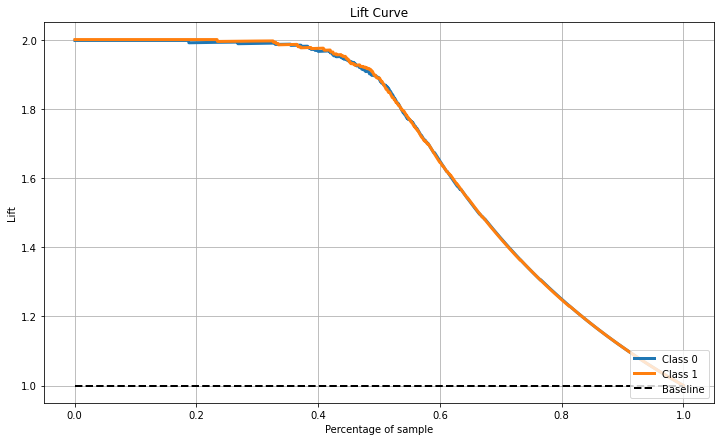

In [22]:
skplt.metrics.plot_lift_curve(ytest, ypred_proba, figsize=(12, 7))

### Precision-Recall Curve

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

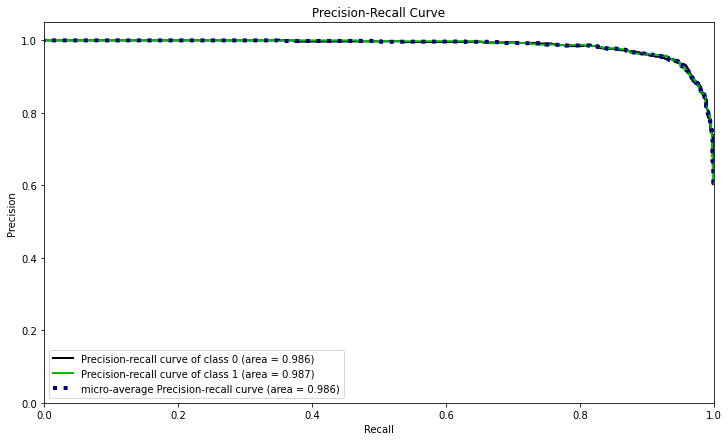

In [23]:

skplt.metrics.plot_precision_recall(ytest, ypred_proba, figsize=(12, 7))

## Interpretability

### Feature Importance

In [92]:
# Feature names generated by TFIDF
fn = lgbm.best_estimator_.named_steps['vectorizer'].get_feature_names()

In [93]:
# Feature Importance in LGBM
fi = lgbm.best_estimator_._final_estimator.feature_importances_

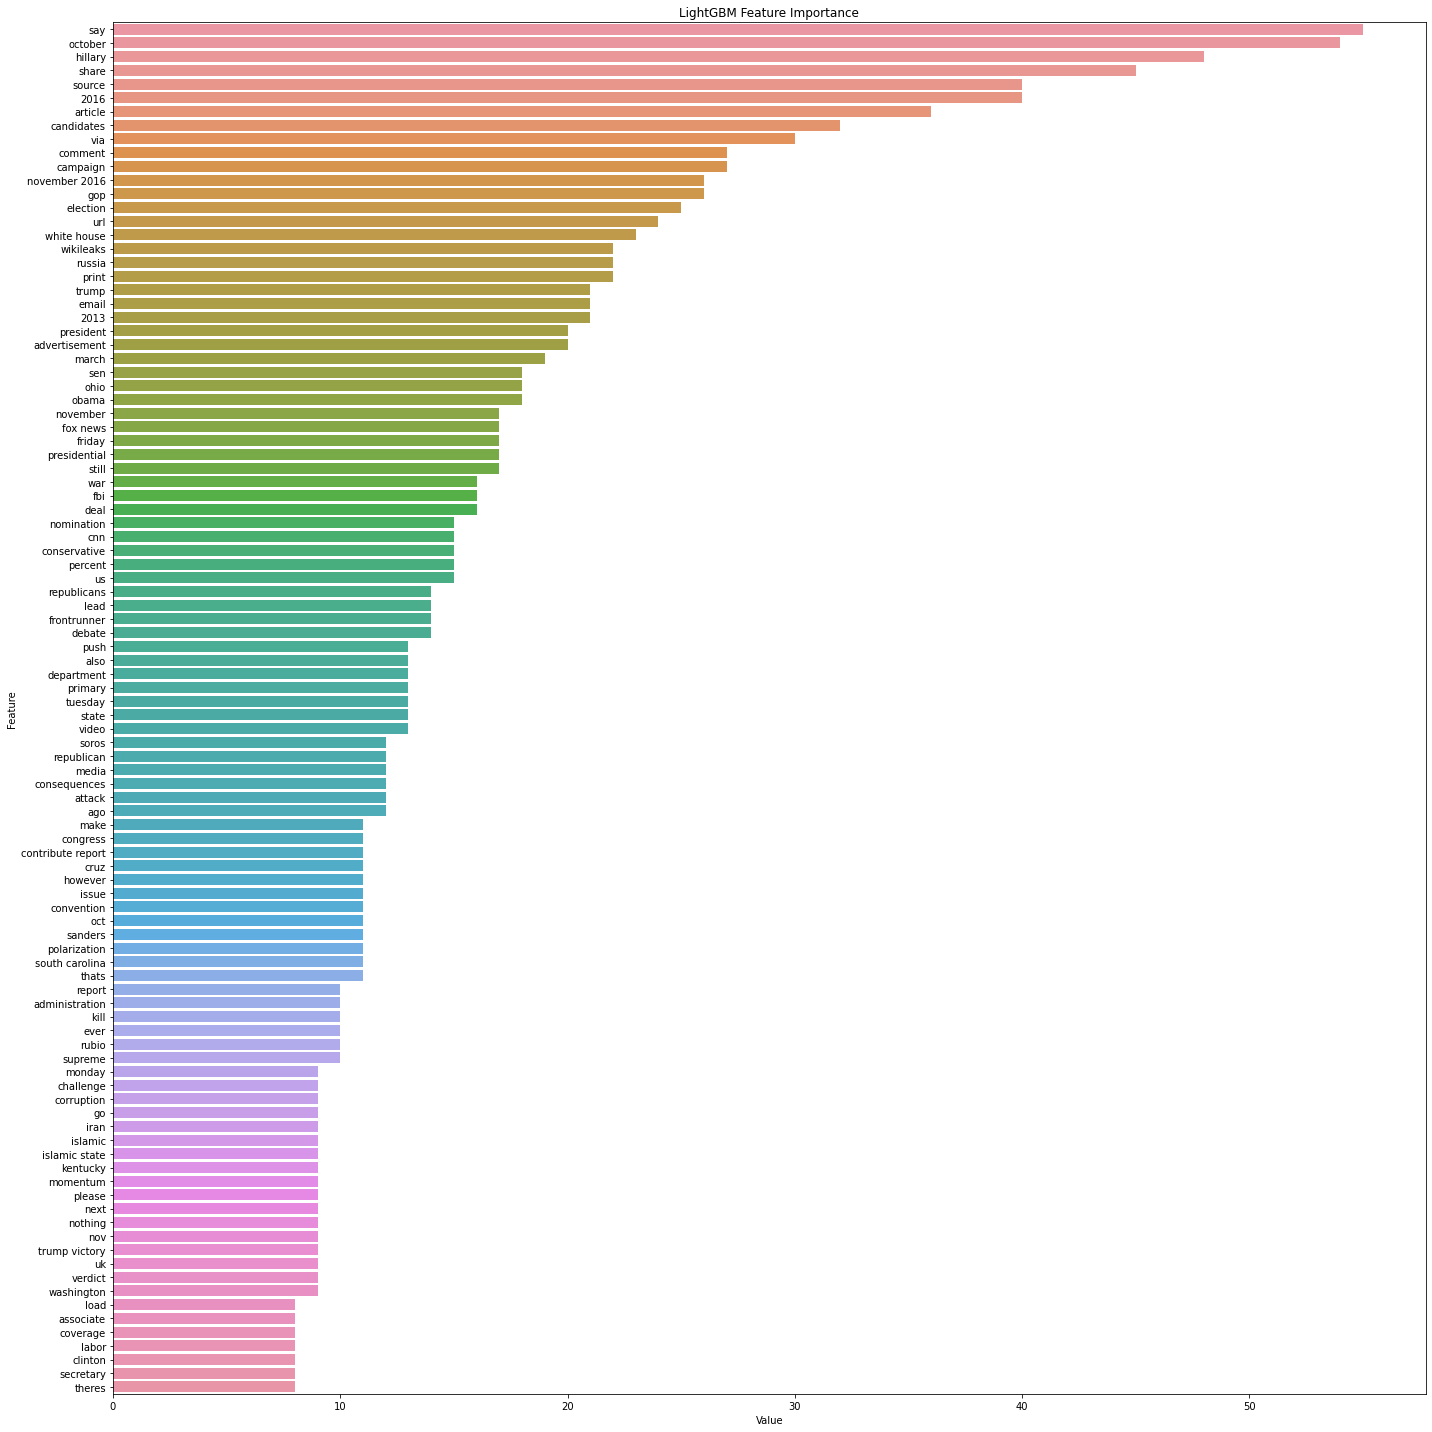

In [94]:
feature_imp = pd.DataFrame(sorted(zip(fi,fn)), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:100])
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

### Shap Values

We have to vectorize the data outside of the original pipeline to get the shap values

In [75]:
pipeline = Pipeline(steps=[
    ("preprocessor", TextPreprocessor()),
    ("vectorizer", TfidfVectorizer(max_df= 0.995,min_df= 0.01,ngram_range= (1, 2),norm='l2'))])

In [83]:
xtrain_transformed = pipeline.fit_transform(xtrain)
xtest_transformed = pipeline.transform(xtest)

In [56]:
shap.initjs()

In [115]:
model = lgbm.best_estimator_.named_steps['clf']
explainer = shap.TreeExplainer(model)

In [117]:
shap_values = explainer.shap_values(xtest_transformed.toarray())

In [142]:
base_value = explainer.expected_value

In [80]:
with open('../models/shap_values.pickle', 'wb') as f:
    pickle.dump(shap_values, f)

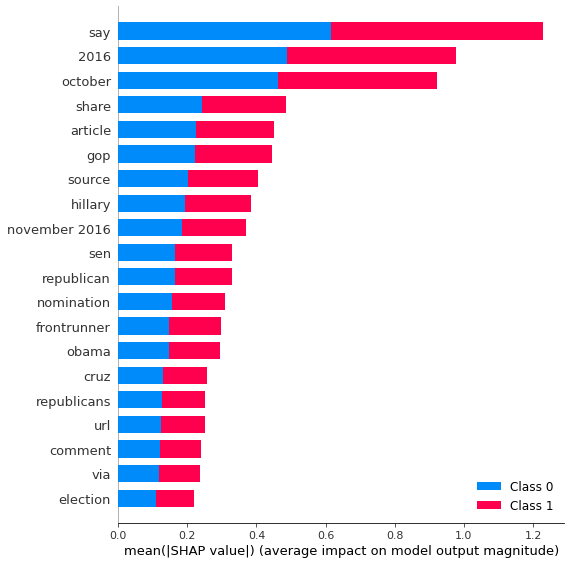

In [123]:
shap.summary_plot(shap_values, xtest_transformed, feature_names =fn)